In [1]:
# requirement
!pip install akshare
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


#### Reading Stocks

In [2]:
# loading packages (pip/pip3 list for new packages) - https://github.com/akfamily/akshare
# pip install akshare --upgrade
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import akshare as ak 

plt.rcParams['font.sans-serif'] = 'Arial Unicode MS' #显示中文
# plt.rcParams['font.sans-serif'] = ['Simhei']  #显示中文
plt.rcParams['axes.unicode_minus'] = False 

/Users/yuanchen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
df_raw = ak.stock_zh_a_spot()
df_raw.columns

In [5]:
df_raw.head

<bound method NDFrame.head of             代码    名称     最新价   涨跌额    涨跌幅      买入      卖出      昨收      今开  \
0     bj430017  星昊医药   12.60 -0.14 -1.099   12.60   12.61   12.74   12.69   
1     bj430047  诺思兰德   16.86 -0.88 -4.961   16.86   16.87   17.74   17.63   
2     bj430090  同辉信息    3.96  0.00  0.000    3.96    3.97    3.96    3.93   
3     bj430139  华岭股份   12.03  0.24  2.036   12.03   12.04   11.79   11.90   
4     bj430198  微创光电    7.67 -0.43 -5.309    7.66    7.67    8.10    8.16   
...        ...   ...     ...   ...    ...     ...     ...     ...     ...   
5350  sz301577  美信科技   63.39 -0.51 -0.798   63.36   63.39   63.90   62.88   
5351  sz301578  辰奕智能   56.79  0.23  0.407   56.72   56.79   56.56   56.69   
5352  sz301588  美新科技   29.49 -1.27 -4.129   29.48   29.49   30.76   30.50   
5353  sz301589  诺瓦星云  464.87  1.27  0.274  463.91  464.89  463.60  464.99   
5354  sz301591  肯特股份   51.38 -1.58 -2.983   51.36   51.38   52.96   52.69   

          最高      最低        成交量          成交额 

In [6]:
df = df_raw[['代码','名称']].copy()
df.rename(columns={'代码': 'symbol', '名称': 'name'}, inplace=True)
symbol_name_dict = df.set_index('symbol')['name'].to_dict()
# symbol_name_dict.get('sh600029')

In [8]:
start_date = "2023-06-01"
end_date = datetime.now().date().strftime("%Y-%m-%d")
stock_list = ['sh600887','sh600754','sh600009','sh600004','sh601127','sz000651']

def get_signal(stock_index):

    stock_data = ak.stock_zh_a_daily(symbol=stock_index, start_date=start_date, end_date=end_date)
    # 计算5日和20日均线
    stock_data["ma5"] = stock_data["close"].rolling(window=5).mean()
    stock_data["ma20"] = stock_data["close"].rolling(window=20).mean()
    # 生成买入/卖出信号（ma5向上穿越ma20/ma5向下穿越ma20）
    stock_data["buy_signal"] = (stock_data["ma5"] > stock_data["ma20"]) & (stock_data["ma5"].shift(1) <= stock_data["ma20"].shift(1))
    stock_data["sell_signal"] = (stock_data["ma5"] < stock_data["ma20"]) & (stock_data["ma5"].shift(1) >= stock_data["ma20"].shift(1))

    return stock_data

##### Visualisation

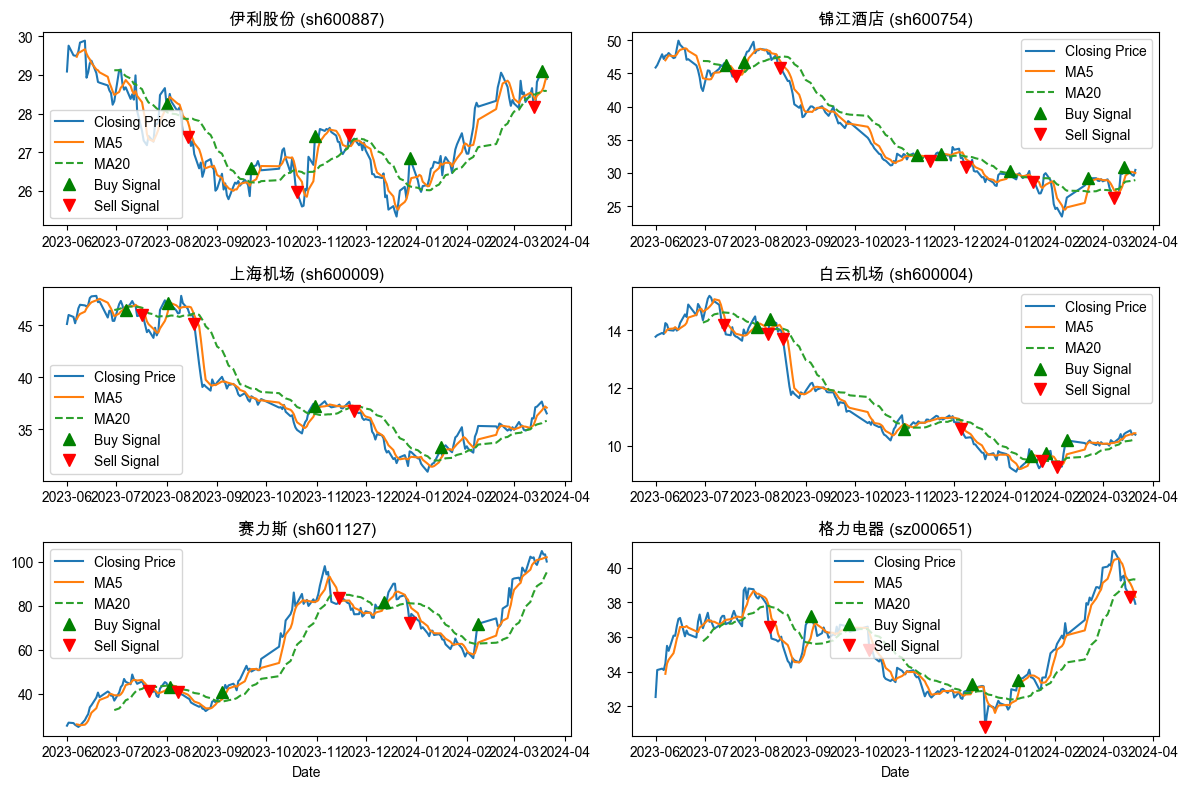

In [9]:
# Create a figure and axes for the subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 8))  # 3 rows, 2 columns

for i, stock_index in enumerate(stock_list):
    stock_data = get_signal(stock_index)
    stock_name = symbol_name_dict.get(stock_index)
    # print(f'{stock_name}: {stock_index}\n')
    
    # Calculate the subplot position
    row = i // 2  # Determine the row index
    col = i % 2   # Determine the column index
    
    # Retrieve the corresponding subplot axes
    ax = axs[row, col]

    # Convert the index into datetime
    stock_data.index = pd.to_datetime(stock_data['date'], format='%Y-%m-%d')
    
    # Plot the closing prices
    ax.plot(stock_data.index, stock_data["close"], label="Closing Price")
    
    # Plot the moving averages (ma5 and ma20)
    ax.plot(stock_data.index, stock_data["ma5"], linestyle='-', label="MA5")
    ax.plot(stock_data.index, stock_data["ma20"], linestyle='--', label="MA20")
    
    # Plot the buy and sell signals
    ax.plot(stock_data[stock_data['buy_signal']]['date'], stock_data[stock_data['buy_signal']]['close'], 'g^', markersize=8, label='Buy Signal')
    ax.plot(stock_data[stock_data['sell_signal']]['date'], stock_data[stock_data['sell_signal']]['close'], 'rv', markersize=8, label='Sell Signal')

    # Set the subplot title and legend
    ax.set_title(f"{stock_name} ({stock_index})")
    ax.legend()
    
    # Set the x-axis label only for the bottom subplots
    if row == 2:
        ax.set_xlabel("Date")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [11]:
stock_data = ak.stock_zh_a_daily(symbol=stock_list[4], start_date=start_date, end_date=end_date)
stock_data

,date,open,high,low,close,volume,amount,outstanding_share,turnover
0,2023-06-01,25.60,25.98,25.10,25.38,19707631.0,5.044448e+08,1.497283e+09,0.013162
1,2023-06-02,25.65,27.05,25.58,26.76,37464869.0,9.946005e+08,1.497283e+09,0.025022
2,2023-06-05,27.00,27.21,26.18,26.57,23793685.0,6.344718e+08,1.497283e+09,0.015891
3,2023-06-06,26.44,26.79,25.70,25.77,17361279.0,4.540838e+08,1.497283e+09,0.011595
4,2023-06-07,25.71,25.95,25.10,25.31,18125132.0,4.611599e+08,1.497283e+09,0.012105
...,...,...,...,...,...,...,...,...,...
191,2024-03-15,98.50,99.80,94.46,98.45,79174729.0,7.716422e+09,1.509782e+09,0.052441
192,2024-03-18,103.00,106.66,102.87,104.76,76469288.0,7.987908e+09,1.509782e+09,0.050649
193,2024-03-19,103.01,105.46,102.50,103.16,48621145.0,5.044855e+09,1.509782e+09,0.032204
194,2024-03-20,103.70,105.77,101.68,103.25,41469439.0,4.293530e+09,1.509782e+09,0.027467


#### Modelling - LSTM

In [52]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras import regularizers

In [44]:
stock_data = ak.stock_zh_a_daily(symbol=stock_list[1], start_date=start_date, end_date=end_date)
# Convert the date column to datetime format
stock_data["date"] = pd.to_datetime(stock_data["date"])
stock_data["day_of_year"] = stock_data["date"].dt.dayofyear

# Sort the data by date in ascending order
stock_data.sort_values("date", inplace=True)

# Normalize the closing price values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
stock_data["close_scaled"] = scaler.fit_transform(stock_data["close"].values.reshape(-1, 1))

##### Training

In [46]:
# Split the data into training and testing sets
train_size = int(len(stock_data) * 0.7)
train_data = stock_data[:train_size]
test_data = stock_data[train_size:]

# Create input sequences and corresponding target values for training
X_train = []
y_train = []

# Define the number of previous time steps to consider
# (e.g., use the previous 10 days' closing prices to predict the next day)
time_steps = 10

for i in range(time_steps, len(train_data)):
    X_train.append(train_data["close_scaled"].values[i - time_steps:i])
    y_train.append(train_data["close_scaled"].values[i])

# Convert the lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape the input data to match the LSTM layer input shape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Create input sequences and corresponding target values for testing
X_test = []
y_test = []

for i in range(time_steps, len(test_data)):
    X_test.append(test_data["close_scaled"].values[i - time_steps:i])
    y_test.append(test_data["close_scaled"].values[i])

# Convert the lists to NumPy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape the input data to match the LSTM layer input shape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [48]:
# Initialize the model
model = Sequential()

# Add an LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))

# Add another LSTM layer with 50 units
model.add(LSTM(units=50))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")
# print(model.summary())

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5270
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3168 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1338 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0390 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0319 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━

##### Model Prediction - LSTM

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


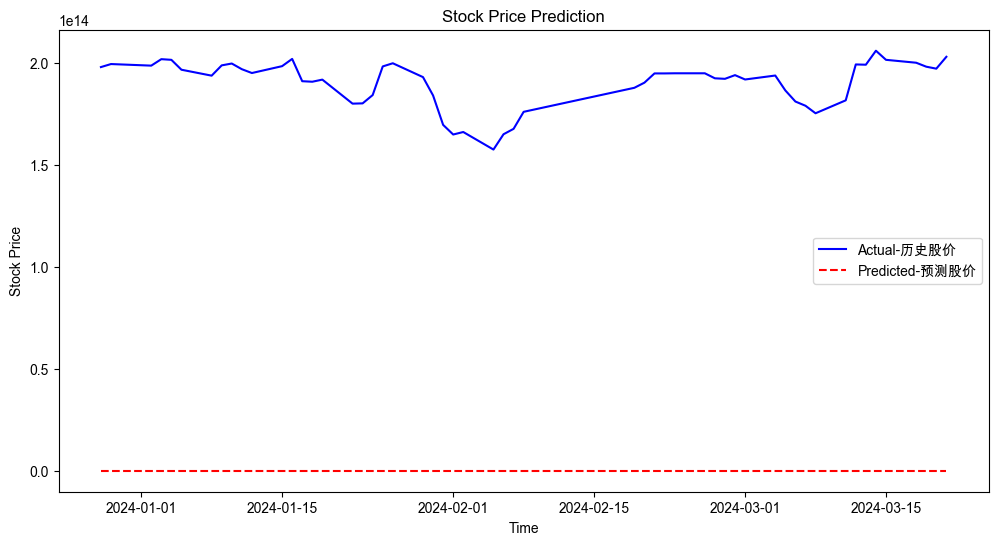

In [33]:
# Generate predictions for the test set
y_pred = model.predict(X_test)

# Rescale the predicted and actual values back to their original range
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_date = test_data[time_steps:]["date"]

# Plot the predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(y_date, y_test, label="Actual-历史股价", color="blue")
plt.plot(y_date, y_pred, label="Predicted-预测股价", color="red", linestyle = "--")
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [67]:
# Finalizing predictions
y_pred = model.predict(X_test)

# Rescale the predicted and actual values back to their original range
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_date = test_data[time_steps:]["date"]

test_preds_df = pd.DataFrame(
    y_test, columns=[f'pred_{i+1}_step' for i in range(y_test.shape[1])])
test_preds_df['true_value'] = test_data['close_scaled'].values[-len(y_pred):]
test_preds_df['naive_pred'] = test_data['close_scaled'].values[-len(y_pred) - 1:-1]

test_preds_df['pred_1_step'] = pd.to_numeric(test_preds_df['pred_1_step'])
test_preds_df['true_value'] = pd.to_numeric(test_preds_df['true_value'])
err = mean_absolute_error(test_preds_df['pred_1_step'].values,test_preds_df['true_value'].values)
#err = mean_squared_error(test_preds_df['pred_1_step'].values,test_preds_df['true_value'].values)
print(f'abs error for testset is {err}')



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
abs error for testset is 9.337806437354897e+19


In [71]:
test_preds_df

,pred_1_step,true_value,naive_pred
0,9.705761e+19,0.228216,0.256507
1,9.562034e+19,0.211241,0.228216
2,9.811161e+19,0.240664,0.211241
3,9.855876e+19,0.245945,0.240664
4,9.718537e+19,0.229725,0.245945
5,9.625913e+19,0.218785,0.229725
6,9.791997e+19,0.238401,0.218785
7,9.967664e+19,0.259147,0.238401
8,9.427889e+19,0.195398,0.259147
9,9.415113e+19,0.193889,0.195398


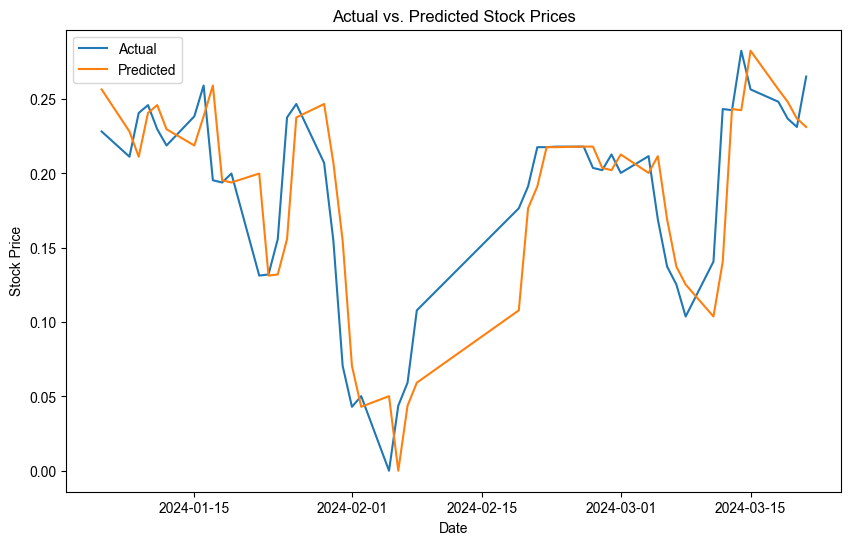

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(y_date, test_preds_df['true_value'], label='Actual')
plt.plot(y_date, test_preds_df['naive_pred'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()